# Supervised Learning - Part II (Chapter 5)

This module focuses on a particular class of supervised machine learning: classification, where we have a finite number of choices to label an observation. 

Topics for this module:
* Cross-Validation
* Learning Curves
* Support Vector Machines
* Random Forest

In [1]:
import numpy as np
import matplotlib.pylab as plt

We ended the last workbook by comparing various classification methods built into the Scikit-Learn toolbox, using the iris dataset.   Lets reproduce those plots using the wine dataset.

In [2]:
from sklearn import datasets # import standard datasets
wine = datasets.load_wine() # load wine data set

as well as the KNN classifier, decision tree, and support vector classification

In [3]:
from sklearn import neighbors
from sklearn import tree
from sklearn import svm

We generated boxplots of accuracy by splitting, fitting and predicting training/test data respectively.  

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

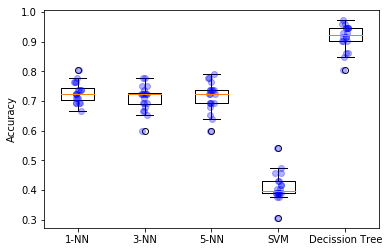

In [32]:
nn1 = neighbors.KNeighborsClassifier(n_neighbors = 1)
nn3 = neighbors.KNeighborsClassifier(n_neighbors = 3)
nn5 = neighbors.KNeighborsClassifier(n_neighbors = 5)
svc = svm.SVC()
dt = tree.DecisionTreeClassifier()

acc = np.zeros((20,5))

for i in xrange(20):
    # split the data
    x_train, x_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.4)

    # train the classifier using the training data
    nn1.fit(x_train, y_train)
    nn3.fit(x_train, y_train)
    nn5.fit(x_train, y_train)
    svc.fit(x_train, y_train)
    dt.fit(x_train, y_train)

    # compute the prediction of the test set using the model
    yhat_nn1 = nn1.predict(x_test)
    yhat_nn3 = nn3.predict(x_test)
    yhat_nn5 = nn5.predict(x_test)
    yhat_svc = svc.predict(x_test)
    yhat_dt = dt.predict(x_test)

    acc[i][0] = accuracy_score(yhat_nn1,y_test)
    acc[i][1] = accuracy_score(yhat_nn3,y_test)
    acc[i][2] = accuracy_score(yhat_nn5,y_test)
    acc[i][3] = accuracy_score(yhat_svc,y_test)
    acc[i][4] = accuracy_score(yhat_dt,y_test)
    
    
# generate box plot
plt.boxplot(acc);
for i in xrange(5):
    # add jigger to plot data
    xderiv = (i+1)*np.ones(acc[:,i].shape)+(np.random.rand(20,)-0.5)*0.1
    plt.plot(xderiv,acc[:,i],'bo',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['1-NN','3-NN','5-NN','SVM','Decission Tree'])
_ = plt.ylabel('Accuracy')


Decision Tree appears to perform the best, based on our simple cross-validation test.  Here, we ran several experiments where we randomly split the data set into a training and a test set, did the prediction, and fit.  This is known as repeated random sub-sampling validation (or Monte Carlo cross-validation).  There are other modes of cross validation:
* *leave-one-out*:  Given $N$ samples, model is trained with $N-1$ samples and tested with the remaining one.  This is repeated $N$ times, once per training sample, and the result is averaged
* *leave-p-out*:  Given $N$ samples, model is trained with $N-p$ samples and tested with the remaining $p$ samples.  This is repeated $N \choose p$ times, and the result is averaged.  This approach is impractical for most choices of $n$ and $p$.
* *k-fold cross-validation*: the data is split into $k$ non-overlapping splits.  Use $k-1$ splits for training, and the remaining split for testing.  Repeat $k$ times, leaving one split out each time, then average the results.

# Decision Trees

Lets learn about decision trees (DT), before switching to errors associated with the learning task.  DTs are a popular method for various machine learning tasks because 
* they are invariant under scaling and various other transformation of feature values (i.e. normalization not needed)
* one can include irrelevant features without affecting the final outcome
* can handle both numerical and categorical data 
* the final outcome is easy to understand / interpret / visualized. 

DT have various downsides however:
* prone to over-fitting (overly-complex trees)
* unstable: small variations in data might result in a completely different generated tree
* optimal decision trees are NP-complete; hence, most algorithms are based on heuristic (e.g. greedy) algorithms

What does a tree look like?

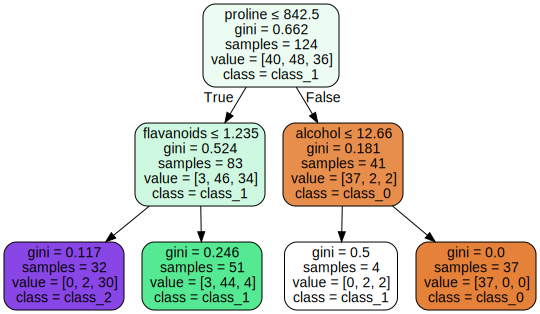

In [38]:
dt = tree.DecisionTreeClassifier(max_depth=2)
x_train, x_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.3)
dt.fit(x_train, y_train)

import graphviz 
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=wine.feature_names,  
                         class_names=wine.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

How to read this tree? 
* top entry in each box gives the condition being tested.  
* gini: is a measure of impurity; how often an randomly chosen element from the set would be incorrectly labeled, 
* samples: number of samples in each leaf
* value: (???) presumably, some values in the data?  I'm not sure.
* class: the targeted output

## How is a tree built?

The general approach is to split a set of samples into subsets based on some attributes, and repeating the process in a recursive manner.  The simplest algorithm is a top-down, greedy search through the space of possible decision trees.
First, one computes the *entropy* for the data set, a measure of uncertainty in the data set, 
$$ H(S) = \sum_{c \in C} -p(c) \log_k{p(c)}.$$
Here,
* $S$ is the current sample set for which entropy is being calculated
* $C$ is the set of classes in $S$
* $k = |C|$ : $k$ is the number of classes
* $p(c)$ is the probability of encountering element in class $c$ in the set $S$.

For a binary classification problem:
* an entropy will be zero if all samples are either true, or if all samples are false.
* if half the samples are true, half the samples are false, then the entropy will be one (i.e. high).

The greedy algorithm proceeds as follows:
* compute entropy of parent
* for each feature/attribute
    * compute information gain:  Entropy(parent) - Weighted Sum of Entropy(Children).
* pick feature that gives largest information gain.

This is then repeated recursively for each leaf in the tree.

Alternatively, Scikit-learn uses a hierarchical approach known as CART (Classification and Regression Trees). The main difference, is the Gini Index is used as the cost function to evaluate splits in the data set.  It is beyond the scope of this course to explore CART and it's variants.  Interested readers should look at:

http://www.uta.edu/faculty/rcli/Teaching/math6310/materials/Ten.pdf#page=192


# Learning Curves

Denote the training error (i.e. in-sample error) as $E_{in}$, i.e., the error in the model measured over all data in the *training* set.   Denote the testing error (i.e. out-of sample error / generalization error) as $E_{out}$, i.e., the error expected on unseen data.  Some intuitive statements:
* $E_{out} \ge E_{in}$
* want $E_{in} \to 0$
* want $E_{out} \approx E_{n}$, i.e.,
$\quad  E_{in} \le E_{out} \le E_{in} + \Omega, \quad \text{with } \Omega \to 0,$ where $\Omega$ typically depends on the number of samples $N$, complexity of the model, ...

Learning curve: shows relationship between training/test errors as a function of ML problem parameters.  We'll use the Decision Tree classifier which seems to work best for this problem.  Additionally, we will control the maximum depth of the tree, in some sense, controlling the complexity of the ML algorithm.

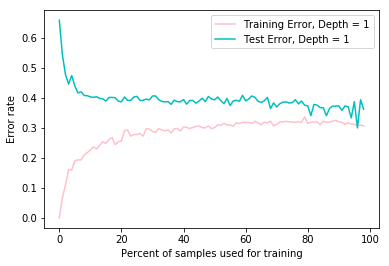

In [35]:
dt = tree.DecisionTreeClassifier(max_depth=1)

Ein = np.zeros((99,40))
Eout = np.zeros((99,40))

for nratio in xrange(99):

    ratio = 1 - (nratio+1)/100.0
    for i in xrange(40):
        # split the data
        x_train, x_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=ratio)

        # train the classifier using the training data
        dt.fit(x_train, y_train)

        # compute the prediction of the test set using the model
        yhat_train = dt.predict(x_train)
        yhat_test = dt.predict(x_test)

        Ein[nratio][i] = 1 - accuracy_score(yhat_train,y_train)
        Eout[nratio][i] = 1 - accuracy_score(yhat_test,y_test)
    
p1,=plt.plot(np.mean(Ein[:,:].T,axis=0),'pink')
p2,=plt.plot(np.mean(Eout[:,:].T,axis=0),'c')
fig = plt.gcf()
#fig.set_size_inches(12,5)
plt.xlabel('Percent of samples used for training')
plt.ylabel('Error rate')
_ = plt.legend([p1,p2],["Training Error, Depth = 1","Test Error, Depth = 1"])    


Observations:
* ? 
* ? 

Lets repeat with a more complicated model (increasing depth of tree permitted)

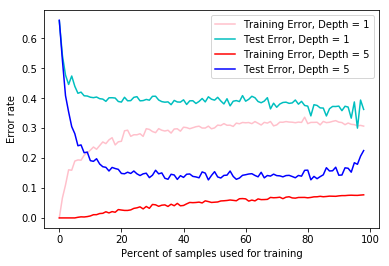

In [36]:
dt = tree.DecisionTreeClassifier(max_depth=2)

# precomputed from above execution block
p1,=plt.plot(np.mean(Ein[:,:].T,axis=0),'pink')
p2,=plt.plot(np.mean(Eout[:,:].T,axis=0),'c')

Ein = np.zeros((99,40))
Eout = np.zeros((99,40))

for nratio in xrange(99):

    ratio = 1 - (nratio+1)/100.0
    for i in xrange(40):
        # split the data
        x_train, x_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=ratio)

        # train the classifier using the training data
        dt.fit(x_train, y_train)

        # compute the prediction of the test set using the model
        yhat_train = dt.predict(x_train)
        yhat_test = dt.predict(x_test)

        Ein[nratio][i] = 1 - accuracy_score(yhat_train,y_train)
        Eout[nratio][i] = 1 - accuracy_score(yhat_test,y_test)
    
p3,=plt.plot(np.mean(Ein[:,:].T,axis=0),'red')
p4,=plt.plot(np.mean(Eout[:,:].T,axis=0),'blue')
fig = plt.gcf()
#fig.set_size_inches(12,5)
plt.xlabel('Percent of samples used for training')
plt.ylabel('Error rate')
_ = plt.legend([p1,p2,p3,p4],["Training Error, Depth = 1","Test Error, Depth = 1","Training Error, Depth = 2","Test Error, Depth = 2"])  

These graphs are not as instructive as those in your textbook, since we are working with the wine data set, rather than the toy problem generated on page 79.  